# Dump data for DDP

## Version 2

Produces one big csv file for each process (1 background, 1 for each signals) with the following columns:

weight, MET, m_dijet, N jets, N b-jets, N electrons, N muons, N photons

For now we can do N jets >= 2 baseline selection and take m_dijet using the pair of leading, subleading jets.

Selected DarKMachine samples satisfy different signatures as defined in test-Parsing code.

The format of the txt files is:

event ID; process ID; event weight; MET; METphi; obj1, E1, pt1, eta1,phi1; obj2, E2, pt2, eta2, phi2; ...

Objects are stored in that order: jets, b-jets, electrons, muons, gammas. For example files in directory channels_2j2b1e0m0g have 25 colums:
* header: event ID; process ID; event weight; MET; METphi = 5
* 2 jets = 2 x 4
* 2 b-jets = 2 x 4
* 1 ele = 1 x 4 

Energies are in MeV

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pathlib import Path

## Available files

In [2]:
###------------------- All available files ------------------------###

### BSM Nfiles corresponding to 10fb (weights=1)
bsm_files_10fb = ['gluino_01_10fb.csv', 'gluino_02_10fb.csv', 'gluino_03_10fb.csv', 'gluino_04_10fb.csv',
'gluino_05_10fb.csv', 'gluino_06_10fb.csv', 'gluino_07_10fb.csv', 'stop_01_10fb.csv',
'stop_02_10fb.csv', 'stop_03_10fb.csv', 'stop_04_10fb.csv', 'Zp_technicol_01_10fb.csv',
'Zp_technicol_02_10fb.csv', 'Zp_technicol_03_10fb.csv', 'Zp_technicol_04_10fb.csv',
'Zp_technicol_05_10fb.csv']

# More generated events (weights<1)
bsm_files_full = ['gluino_01_p_p_to_go_go_0_0.2013275_21.csv',
'gluino_02_p_p_to_go_go_0_0.0508105_30.csv',
'gluino_03_p_p_to_go_go_0_0.0144098_39.csv',
'gluino_04_p_p_to_go_go_0_0.00442036_48.csv',
'gluino_05_p_p_to_go_go_0_0.00143275_84.csv',
'gluino_06_p_p_to_go_go_0_0.0004843405_66.csv',
'gluino_07_p_p_to_go_go_0_0.000168185_75.csv',
'stop_01_p_p_to_t1_t1~0_26.7494500003_39.csv',
'stop_02_p_p_to_t1_t1~0_5.69774999996_48.csv',
'stop_03_p_p_to_t1_t1~0_1.2483025_75.csv',
'stop_04_p_p_to_t1_t1~0_0.0200922000001_84.csv', 'Zp_technicol_01_0.3865.csv',
'Zp_technicol_02_0.12206.csv', 'Zp_technicol_03_0.044272.csv',
'Zp_technicol_04_0.017957.csv', 'Zp_technicol_05_0.00807869999999.csv']

# Just Z'
bsm_files_Zprime = ['Zp_technicol_01_0.3865.csv',
'Zp_technicol_02_0.12206.csv', 'Zp_technicol_03_0.044272.csv',
'Zp_technicol_04_0.017957.csv', 'Zp_technicol_05_0.00807869999999.csv']

### SM: Nfiles corresponding to 10fb (weights=1)
sm_files_10fb = ['2gam_10fb.csv', '4top_10fb.csv', 'atop_10fb.csv', 'atopbar_10fb.csv',
'gam_jets_10fb.csv', 'njets_10fb.csv', 'single_higgs_10fb.csv', 'single_top_10fb.csv',
'single_topbar_10fb.csv', 'ttbar_10fb.csv', 'ttbarGam_10fb.csv', 'ttbarHiggs_10fb.csv',
'ttbarW_10fb.csv', 'ttbarWW_10fb.csv', 'ttbarZ_10fb.csv', 'Wgam_10fb.csv',
'w_jets_10fb.csv', 'wtop_10fb.csv', 'wtopbar_10fb.csv', 'ww_10fb.csv', 'Zgam_10fb.csv',
'z_jets_10fb.csv', 'ztop_10fb.csv', 'ztopbar_10fb.csv', 'zw_10fb.csv', 'zz_10fb.csv']

# --> selected processes more relevant to top analyses (but no QCD, no 4top)
sm_files_10fb_top_noqcd = ['single_top_10fb.csv', 'single_topbar_10fb.csv', 'ttbar_10fb.csv','ttbarW_10fb.csv', 'ttbarWW_10fb.csv', 'ttbarZ_10fb.csv', 'w_jets_10fb.csv', 'wtop_10fb.csv', 'wtopbar_10fb.csv', 'ww_10fb.csv', 'Zgam_10fb.csv',
'z_jets_10fb.csv', 'ztop_10fb.csv', 'ztopbar_10fb.csv', 'zw_10fb.csv', 'zz_10fb.csv']

# Same with less processes (remove minor ones)
sm_files_10fb_top_noqcd_redux = ['single_top_10fb.csv', 'single_topbar_10fb.csv', 'ttbar_10fb.csv', 'w_jets_10fb.csv', 'wtop_10fb.csv', 'wtopbar_10fb.csv', 'ww_10fb.csv', 'z_jets_10fb.csv', 'zw_10fb.csv', 'zz_10fb.csv']

# Same with less processes and w/o wtop and ww (bugged?)
sm_files_10fb_top_noqcd_redux2 = ['single_top_10fb.csv', 'single_topbar_10fb.csv', 'ttbar_10fb.csv', 'w_jets_10fb.csv', 'z_jets_10fb.csv', 'zw_10fb.csv', 'zz_10fb.csv']

# --> process gamma-gamma + Higgs (no QCD, no top)
sm_files_10fb_gamma_noqcd = ['2gam_10fb.csv','gam_jets_10fb.csv','single_higgs_10fb.csv','Wgam_10fb.csv','Zgam_10fb.csv']

### SM: More generated events w/ at least 20000 lines (weights<1)
sm_files_min20000 = ['4top_min20000_0.0096595986.csv', 'atopbar_min20000_0.270715462961.csv',
'atop_min20000_0.394719941825.csv', 'single_higgs_min20000_1.93837414875.csv',
'ttbarGam_min20000_1.547189548.csv', 'ttbarHiggs_min20000_0.45681409215.csv',
'ttbarW_min20000_0.34959.csv', 'ttbarWW_min20000_0.0085169756.csv',
'ttbarZ_min20000_0.5874599.csv', 'ztopbar_min20000_0.15244566525.csv',
'ztop_min20000_0.255457848625.csv']

### Hackathon: "../Data/DarkMachines/hackathon"
hack={}
hack['chan1']  = ['background_chan1_7.79.csv','glgl1400_neutralino1100_chan1.csv','glgl1600_neutralino800_chan1.csv','monojet_Zp2000.0_DM_50.0_chan1.csv','monotop_200_A_chan1.csv','sqsq1_sq1400_neut800_chan1.csv','sqsq_sq1800_neut800_chan1.csv','stlp_st1000_chan1.csv','stop2b1000_neutralino300_chan1.csv']
hack['chan2a'] = ['background_chan2a_309.6.csv','chaneut_cha200_neut50_chan2a.csv','chaneut_cha250_neut150_chan2a.csv','chaneut_cha300_neut100_chan2a.csv','chaneut_cha400_neut200_chan2a.csv','gluino_1000.0_neutralino_1.0_chan2a.csv','pp23mt_50_chan2a.csv','pp24mt_50_chan2a.csv']
hack['chan2b'] = ['background_chan2b_7.8.csv','chacha_cha300_neut140_chan2b.csv','chacha_cha400_neut60_chan2b.csv','chacha_cha600_neut200_chan2b.csv','chaneut_cha200_neut50_chan2b.csv','chaneut_cha250_neut150_chan2b.csv','gluino_1000.0_neutralino_1.0_chan2b.csv','pp23mt_50_chan2b.csv','pp24mt_50_chan2b.csv','stlp_st1000_chan2b.csv']
hack['chan3']  = ['background_chan3_8.02.csv','glgl1400_neutralino1100_chan3.csv','glgl1600_neutralino800_chan3.csv','gluino_1000.0_neutralino_1.0_chan3.csv','monojet_Zp2000.0_DM_50.0_chan3.csv','monotop_200_A_chan3.csv','monoV_Zp2000.0_DM_1.0_chan3.csv','sqsq1_sq1400_neut800_chan3.csv','sqsq_sq1800_neut800_chan3.csv','stlp_st1000_chan3.csv','stop2b1000_neutralino300_chan3.csv']

### Secret dataset: "../Data/DarkMachines/secret_dataset"
secret={}
secret['chan1']  = ['unlabeled_combined_chan1.csv']
secret['chan2a'] = ['unlabeled_combined_chan2a.csv']
secret['chan2b'] = ['unlabeled_combined_chan2b.csv']
secret['chan3']  = ['unlabeled_combined_chan3.csv']

# Details samples
#chan1: >=4 jets, high Ht (bckgd 214k evts: 88% njets, 5% ttbar, 5% W/Z+jets, 1% Wtop)
#chan2a: 3 leptons, MET (low stat)
#chan2b: 2 leptons, MET, Ht
#chan3: Ht, MET

## File to process and selection

WARNING: W/γ/Z+jets and QCD jet production have applied cuts on HT > 100 GeV and 600 GeV, respectively

Event selection array of the form [N jets, N b-jets, N electrons, N muons, N photons]


In [3]:
# channel
#channel = 'chan1'
channel = 'chan3'

In [4]:
### CHAN3: ttbar-like selection
# N objects of each type [MIN,MAX]

NJETS=[6,7]
NBJETS=[0,2]
NELEC=[0,1]
NMUON=[0,1]
NGAMMA=[0,0]

selection=[]
nsel = 0
for nj in range(NJETS[0],NJETS[1]+1):
    for nb in range(NBJETS[0],NBJETS[1]+1):
        for ne in range(NELEC[0],NELEC[1]+1):
            for nm in range(NMUON[0],NMUON[1]+1):
                for ng in range(NGAMMA[0],NGAMMA[1]+1):
                    #print(nj,nb,ne,nm,ng)
                    selection += [[nj,nb,ne,nm,ng]]
                    nsel += 1
print(nsel," selections")
print(selection)

24  selections
[[6, 0, 0, 0, 0], [6, 0, 0, 1, 0], [6, 0, 1, 0, 0], [6, 0, 1, 1, 0], [6, 1, 0, 0, 0], [6, 1, 0, 1, 0], [6, 1, 1, 0, 0], [6, 1, 1, 1, 0], [6, 2, 0, 0, 0], [6, 2, 0, 1, 0], [6, 2, 1, 0, 0], [6, 2, 1, 1, 0], [7, 0, 0, 0, 0], [7, 0, 0, 1, 0], [7, 0, 1, 0, 0], [7, 0, 1, 1, 0], [7, 1, 0, 0, 0], [7, 1, 0, 1, 0], [7, 1, 1, 0, 0], [7, 1, 1, 1, 0], [7, 2, 0, 0, 0], [7, 2, 0, 1, 0], [7, 2, 1, 0, 0], [7, 2, 1, 1, 0]]


In [5]:
### SM
DATAPATH="../Data/DarkMachines/hackathon/%s" % channel
files_to_process_sm = [hack[channel][0]]

### BSM signal
DATAPATH2="../Data/DarkMachines/hackathon/%s" % channel
files_to_process_bsm = hack[channel][1:]

## Read files

read files and return dictionary. To be ran for each selections.

In [6]:
def ReadFiles(filelist, path, sel):
    '''
    filelist: dataset to read
    path: dataset location
    sel: signature to select for this dataset
    '''
    
    nj,nb,ne,nm,ng = sel
    dirname="%s/selections/channels_%dj%db%de%dm%dg" % (path,nj,nb,ne,nm,ng)

    # Rename dataframe colums
    name_columns = ['ID', 'process', 'weight', 'MET', 'METphi']
    for ind in range(nj):
        name_columns += ['j%d_E'%(ind+1), 'j%d_pt'%(ind+1), 'j%d_eta'%(ind+1), 'j%d_phi'%(ind+1)]
    for ind in range(nb):
        name_columns += ['b%d_E'%(ind+1), 'b%d_pt'%(ind+1), 'b%d_eta'%(ind+1), 'b%d_phi'%(ind+1)]
    for ind in range(ne):
        name_columns += ['e%d_E'%(ind+1), 'e%d_pt'%(ind+1), 'e%d_eta'%(ind+1), 'e%d_phi'%(ind+1)]
    for ind in range(nm):
        name_columns += ['m%d_E'%(ind+1), 'm%d_pt'%(ind+1), 'm%d_eta'%(ind+1), 'm%d_phi'%(ind+1)]
    for ind in range(ng):
        name_columns += ['g%d_E'%(ind+1), 'g%d_pt'%(ind+1), 'g%d_eta'%(ind+1), 'g%d_phi'%(ind+1)]

    # Fill dictionary
    dico = dict()        
    for filename in filelist:
        filepath = "%s/%s" % (dirname,filename)
        ff = filename.split(sep='_')
        processname = ff[0] if len(ff)<=2 else ff[0]+'_'+ff[1]
        # print(processname)
        dico[processname] = pd.read_csv(filepath,delimiter=',',names=name_columns,skiprows=1,index_col=False)
    return dico, name_columns

## Save files

In [7]:
def savefile(filename,selection,df):
    nj,nb,ne,nm,ng = selection

    # Add selection columns to dataframe
    df['nj']=nj
    df['nb']=nb
    df['ne']=ne
    df['nm']=nm
    df['ng']=ng
    
    # Create output dir
    dirname="%s/DDP/%s/merge" % (".",channel)
    Path(dirname).mkdir(parents=True, exist_ok=True)
    
    # append output file
    outfile=dirname+"/"+filename
    #df.to_csv(outfile,mode='a',float_format='%.3e',index=False)
    
    with open(outfile, 'a') as f:
        df.to_csv(f, float_format='%.3e',index=False, header=f.tell()==0)

## Plot stacked histograms

In [8]:
def PlotStack(dico,bins,xvar,w):
    '''
    dico: dictionnary
    bins: bin range
    xvar: variable to plot
    w: weights
    '''
    # Incorrect way of doing it
    # see: https://stackoverflow.com/questions/18449602/matplotlib-creating-stacked-histogram-from-three-unequal-length-arrays
    #bins = np.linspace(0, 1e+06, 50)
    #for i in bkg:
    #    plt.hist(bkg[i]['5'], bins = bins,  density=False, histtype='bar', stacked=True, weights=bkg[i]['2'],  label = i)
    #plt.legend(loc='best')

    # Correct way of doing it
    processlist=[]
    weights=[]
    labels=[]
    for i in bkg:
        processlist += [dico[i][xvar]]
        weights += [dico[i][w]]
        labels += [i]

    #plt.figure(figsize=(8,8))
    _ = plt.hist(processlist, bins = bins,  density=False, histtype='bar', stacked=True, weights=weights,label=labels)
    plt.xlabel(xvar)
    plt.legend(loc='best')


## Add features

In [9]:
def addfeatures(df,list_Htall,list_Ht):
    '''
    Add Ht (all) and Ht (jets)
    '''
    df['Htall'] = df[list_Htall].sum(axis=1)
    df['Ht'] = df[list_Ht].sum(axis=1)

##  Lorentz vector calculations

In [10]:
# Lorentz vector library
import skhep
import skhep.math.vectors as vectors

In [11]:
def extravar(*args):
    '''
    Calculate extra 4-vector variables: 4-vectors in *args are summed up and the
    mass, pt, eta, phi of the resulting 4-vector system is calculated
    '''
    v = vectors.LorentzVector()
    for arg in args:
        vv = vectors.LorentzVector()
        vv.setptetaphie(*arg)
        v += vv
    syst_mass = v.m
    syst_pt  = v.pt
    syst_eta = v.pseudorapidity
    syst_phi = v.phi()
    return syst_mass,syst_pt, syst_eta, syst_phi

def CalcObservables(maxevents,label,*args):
    '''
    Run calculation of extravar on events:
    - maxevents: number of events to process
    - label: string to name extra variables (ex: 'dijet')
    - *args: list of 4-vector arrays of size (maxevents,4)
    '''
    obslist = []
    for evt in range(maxevents):
        obj_all =[]
        for obj in args:
            obj_all += [obj[evt]]
        obs = np.array(extravar(*obj_all))
        obslist = np.append(obslist,obs,axis=0)
    #print(maxevents)
    if (maxevents>0):
        obslist = obslist.reshape(maxevents,-1)
    return pd.DataFrame(data=obslist, columns=['%s_mass'%label,'%s_pt'%label,'%s_eta'%label, '%s_phi'%label])

## Add extra 4-vectors properties
Signature-dependent !

In [12]:
def add4vect_dijet(data, sel):
    '''
    Calculate dijet mass if nj+nb>=2 following this rule:
        if nb=0: m(j1,j2)
        if nb=1: m(j1,b1)
        if nb>=2: m(b1,b2)
    - data: dictionnary with all processes
    - sel: selection in [nj,nb,ne,nm,ng] format
    '''
    
    nj,nb,ne,nm,ng = sel

    if (nj+nb>=2):
        for i in data:
            df = data[i]
            
            objects = []
            if (nb==0):
                j1 = df.loc[:,['j1_pt','j1_eta','j1_phi','j1_E']].values
                j2 = df.loc[:,['j2_pt','j2_eta','j2_phi','j2_E']].values
                objects =[j1,j2]
            elif (nb==1):
                j1 = df.loc[:,['j1_pt','j1_eta','j1_phi','j1_E']].values
                b1 = df.loc[:,['b1_pt','b1_eta','b1_phi','b1_E']].values
                objects =[j1,b1]
            elif (nb>=2):
                b1 = df.loc[:,['b1_pt','b1_eta','b1_phi','b1_E']].values
                b2 = df.loc[:,['b2_pt','b2_eta','b2_phi','b2_E']].values
                objects =[b1,b2]

            dxvar = CalcObservables(df.shape[0],'dijet',*objects)
            dd =[]
            dd += [df]
            dd += [dxvar]        
            df_new = pd.concat(dd,axis=1)
            data[i] = df_new
    else:
        print('Warning: no objects selected to build dijet mass !')       

In [13]:
# Alternative to automatically calculate system
# See: https://towardsdatascience.com/interesting-ways-to-select-pandas-dataframe-columns-b29b82bbfb33
##bkg['background_chan1'].loc[:,[True if re.search('%d+'%1,column) else False for column in df.columns]]

def add4vect_system(data,sel):
    '''
    Calculate invariant mass of full system
    add 4-vector calculation to dataset
    - data: dictionnary with all processes
    - sel: selection in [nj,nb,ne,nm,ng] format
    '''
    # loop on processes
    for i in data:
        df = data[i]
        
        objects = []
        # loop on objects
        for part in ["j","b","e","m","g"]:
            #print(part)
            # loop on number of objects
            for n in range(1,7):
                # select 4-vectors corresponding to part and n
                ddd = df.loc[:,[True if re.search('%s%d+'%(part,n),column) else False for column in df.columns]]
                if (ddd.shape[1]>0):
                    #print(i,':',part,'#',n)
                    # reorder columns in pt, eta, phi, E
                    ddd = ddd[['%s%d_pt'%(part,n),'%s%d_eta'%(part,n),'%s%d_phi'%(part,n),'%s%d_E'%(part,n)]]
                    #print(ddd.columns)
                    objects += [ddd.values]

        # Reconstruct objects system and calculate extra variables
        if(len(objects)>0):
            dxvar = CalcObservables(df.shape[0],'syst',*objects)
            dd =[]
            dd += [df]
            dd += [dxvar]        
            df_new = pd.concat(dd,axis=1)
            data[i] = df_new
        else:
            print('Warning: no objects selected to build system !')

## Loop signatures and dump files


selection: [6, 0, 0, 0, 0]

selection: [6, 0, 0, 1, 0]

selection: [6, 0, 1, 0, 0]

selection: [6, 0, 1, 1, 0]

selection: [6, 1, 0, 0, 0]

selection: [6, 1, 0, 1, 0]

selection: [6, 1, 1, 0, 0]

selection: [6, 1, 1, 1, 0]

selection: [6, 2, 0, 0, 0]

selection: [6, 2, 0, 1, 0]

selection: [6, 2, 1, 0, 0]

selection: [6, 2, 1, 1, 0]

selection: [7, 0, 0, 0, 0]

selection: [7, 0, 0, 1, 0]

selection: [7, 0, 1, 0, 0]

selection: [7, 0, 1, 1, 0]

selection: [7, 1, 0, 0, 0]

selection: [7, 1, 0, 1, 0]

selection: [7, 1, 1, 0, 0]

selection: [7, 1, 1, 1, 0]

selection: [7, 2, 0, 0, 0]


<ipython-input-14-39a718c1ebfa>:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 12))



selection: [7, 2, 0, 1, 0]

selection: [7, 2, 1, 0, 0]

selection: [7, 2, 1, 1, 0]


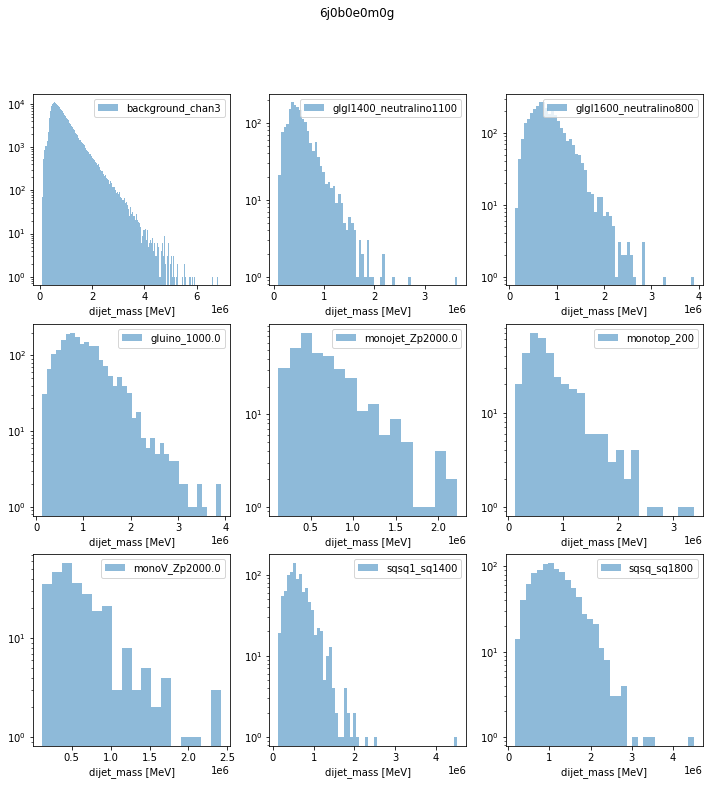

/home/donini/anaconda3/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


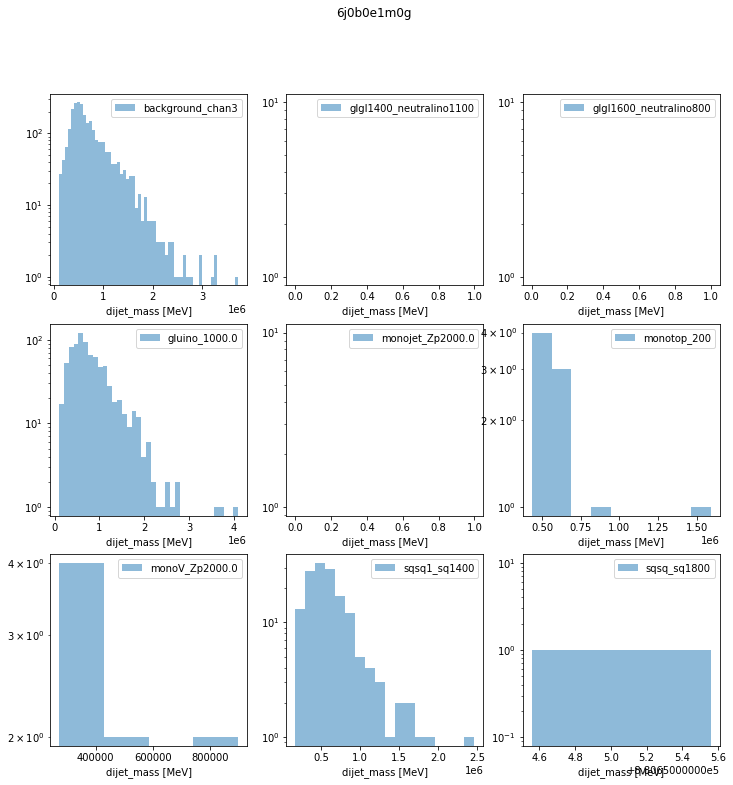

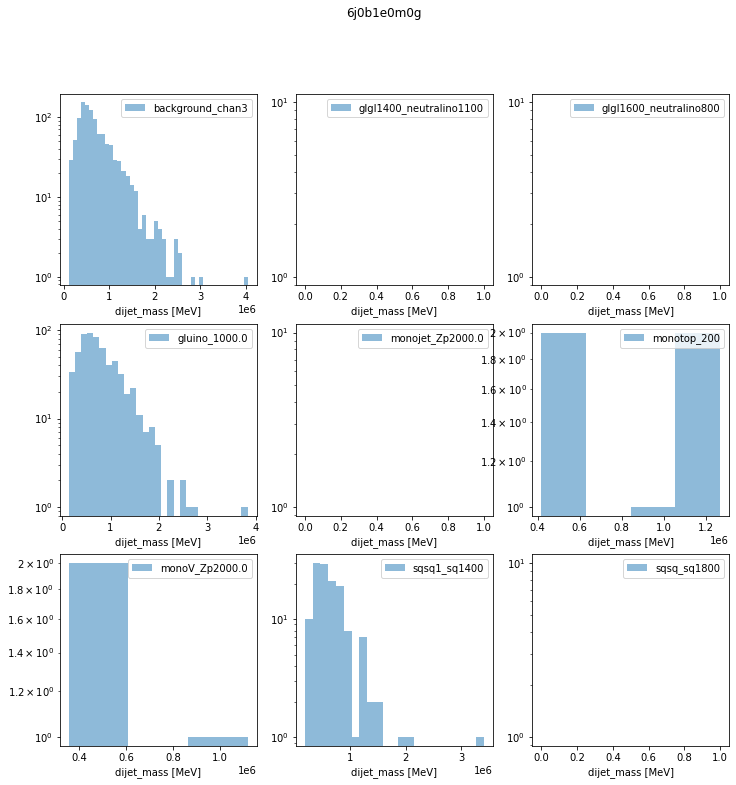

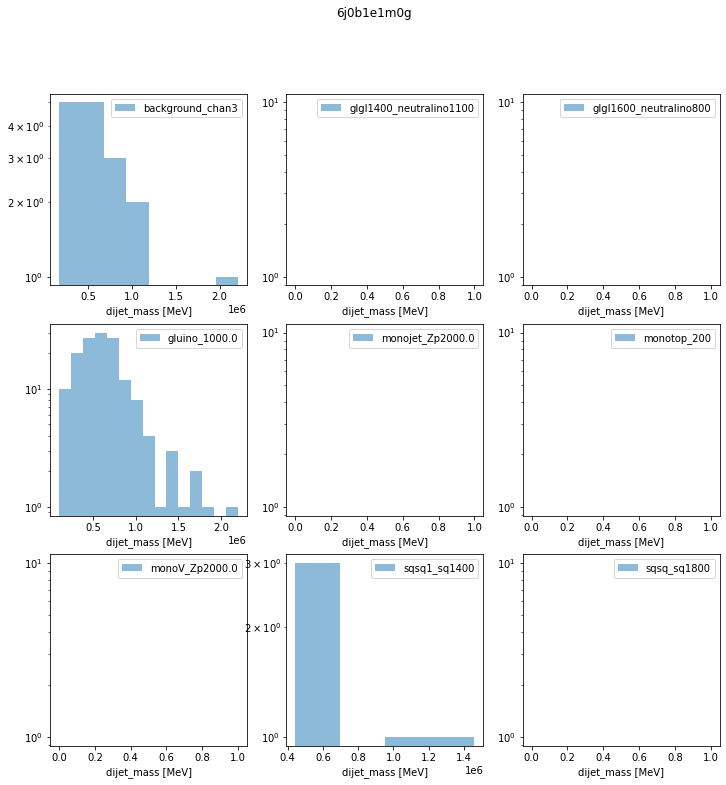

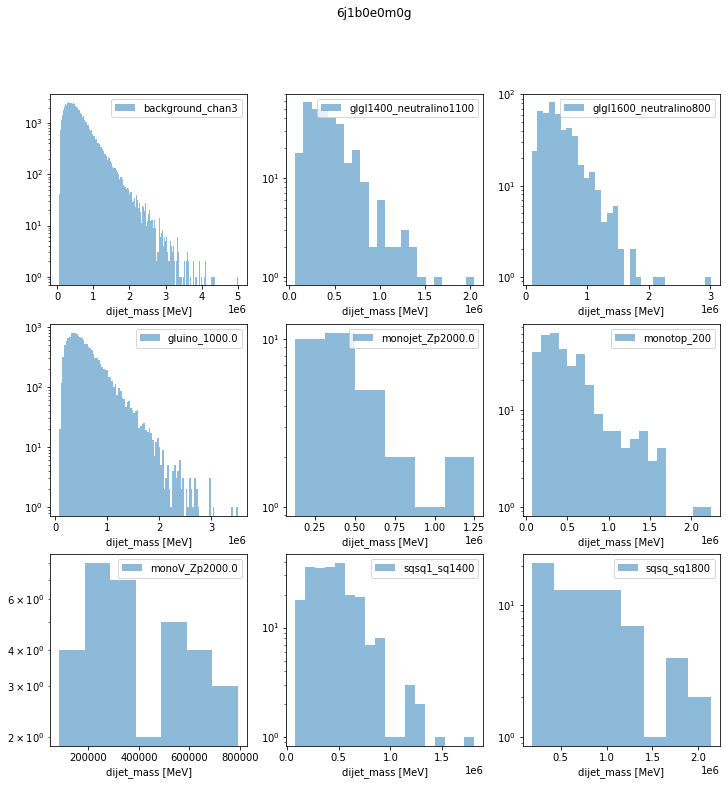

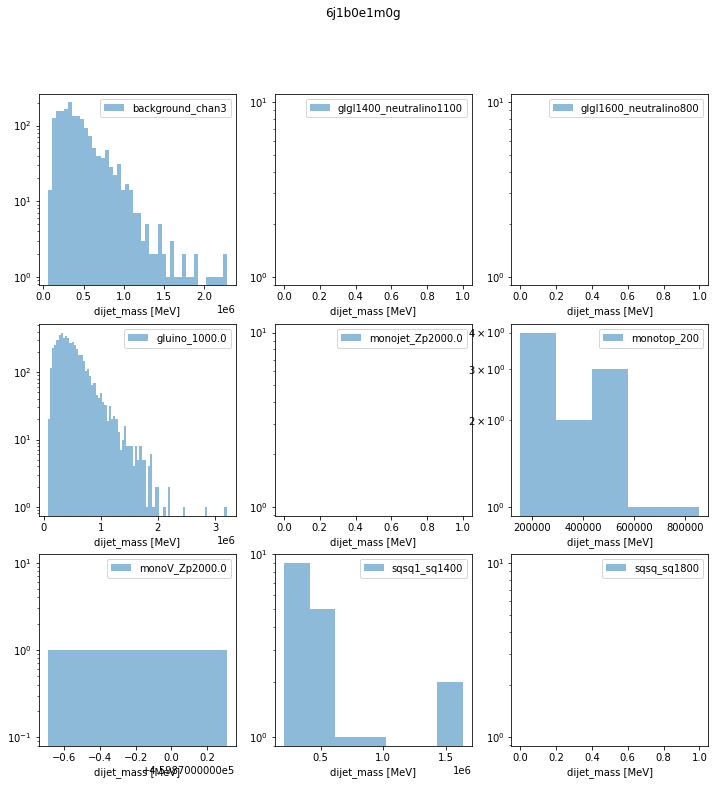

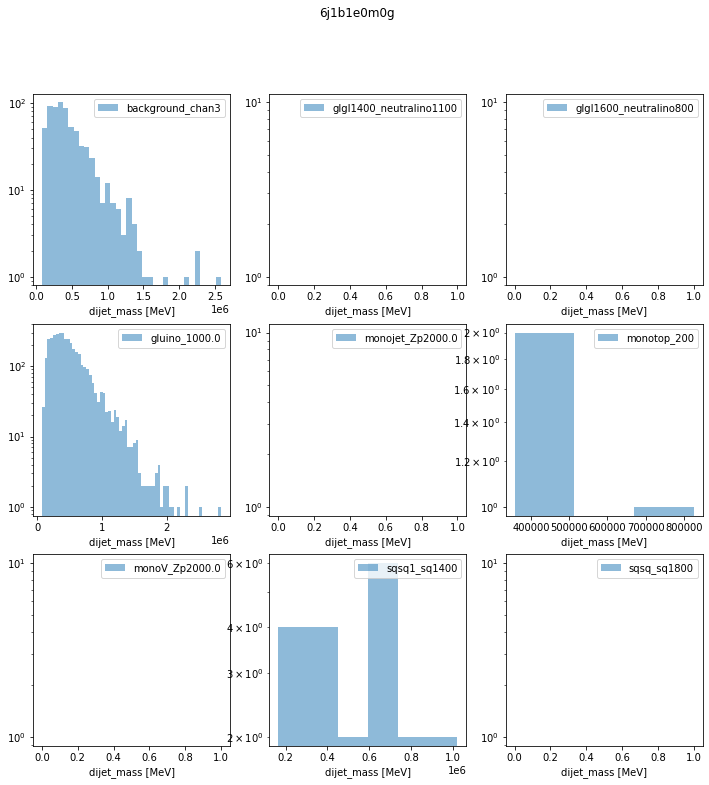

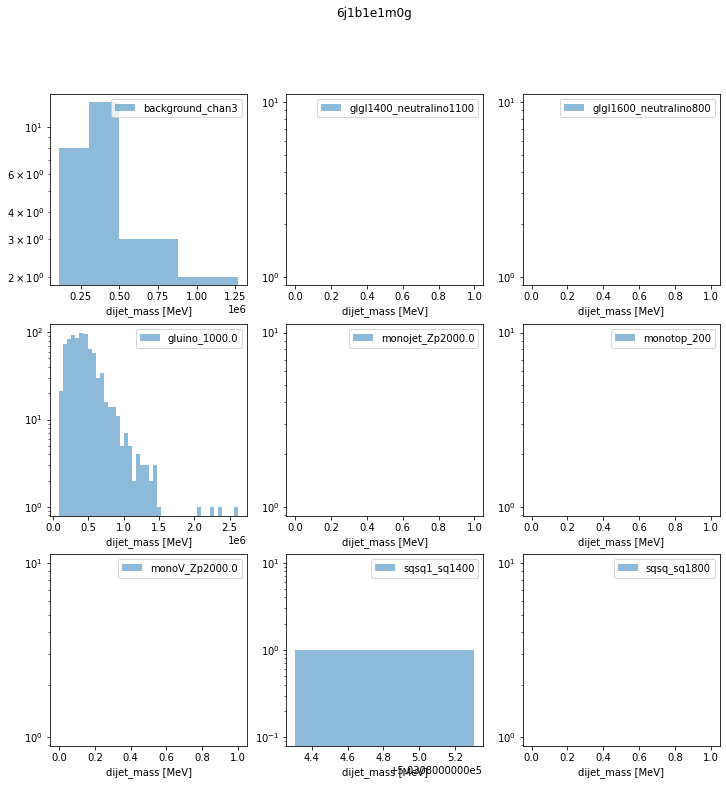

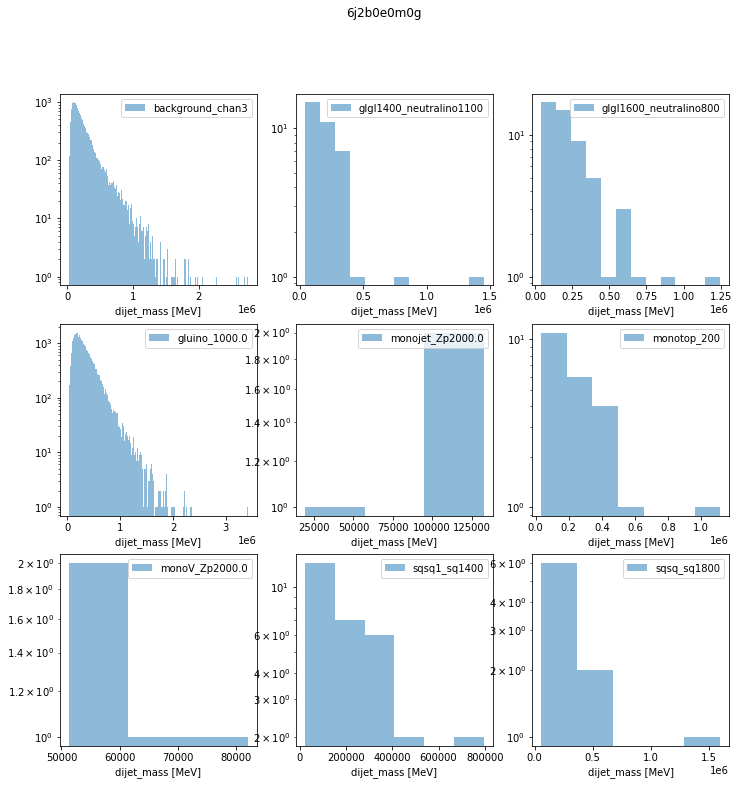

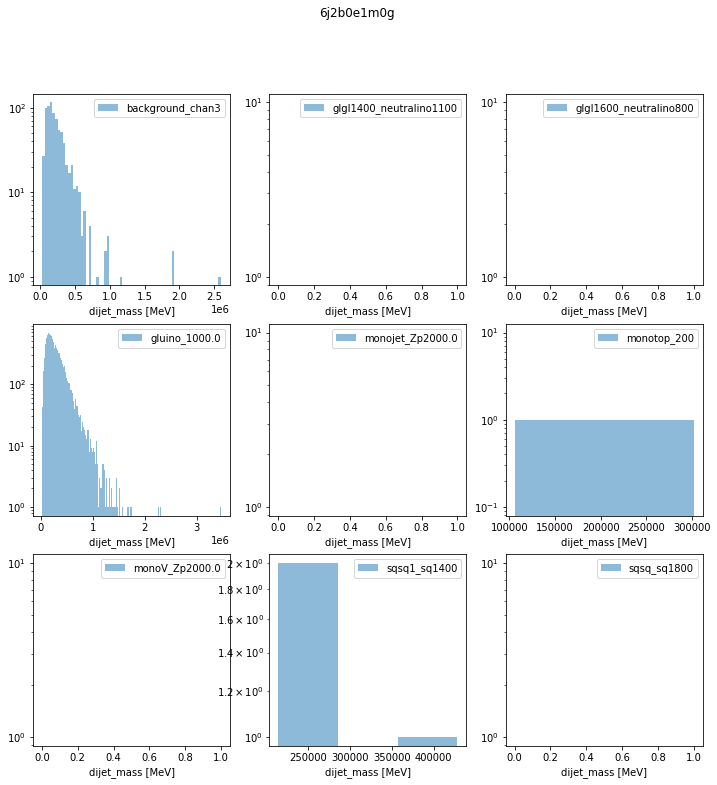

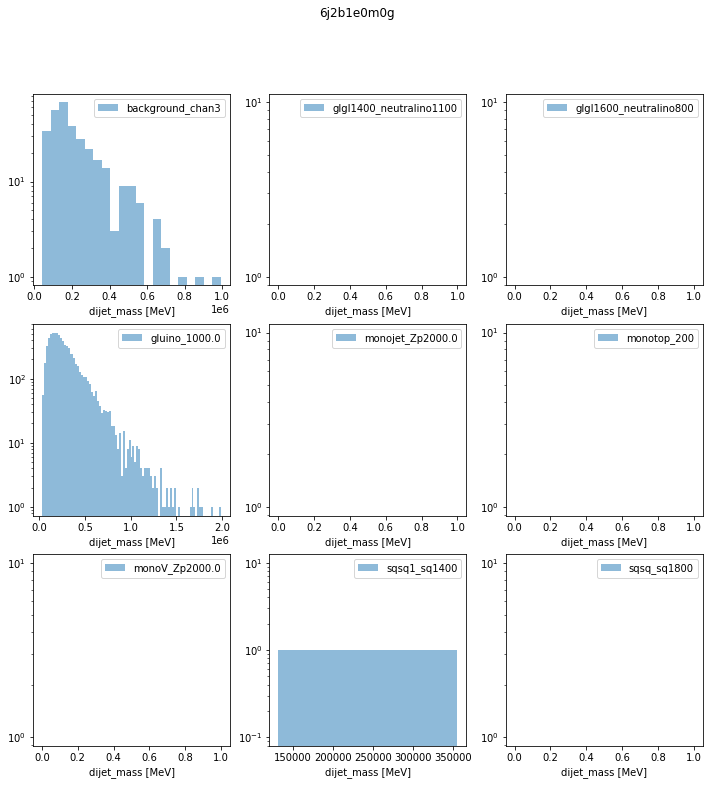

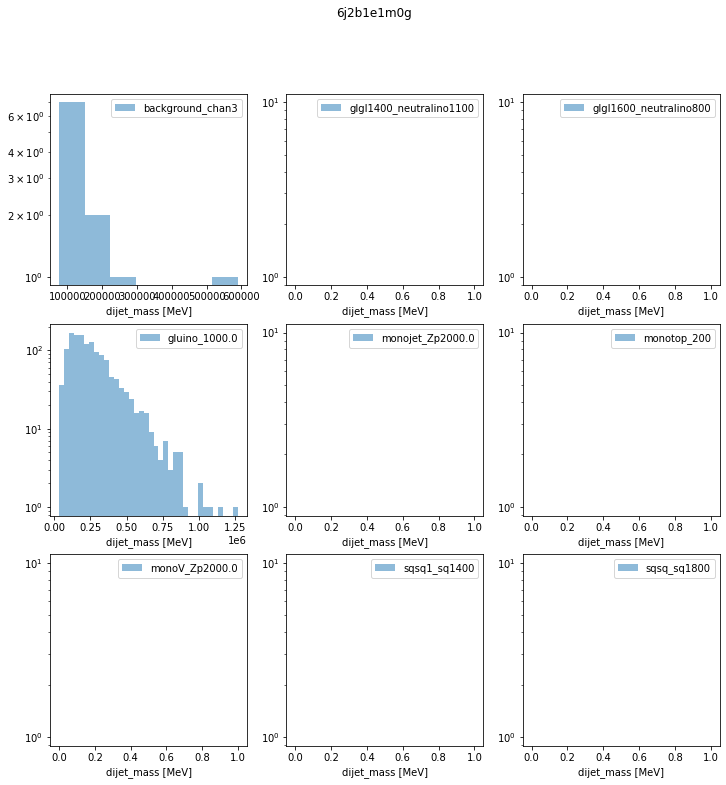

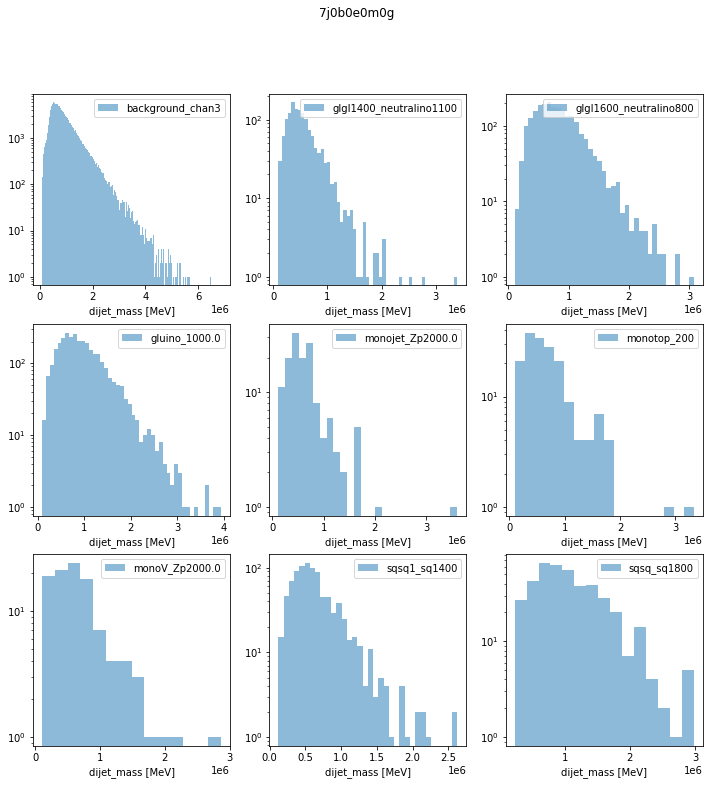

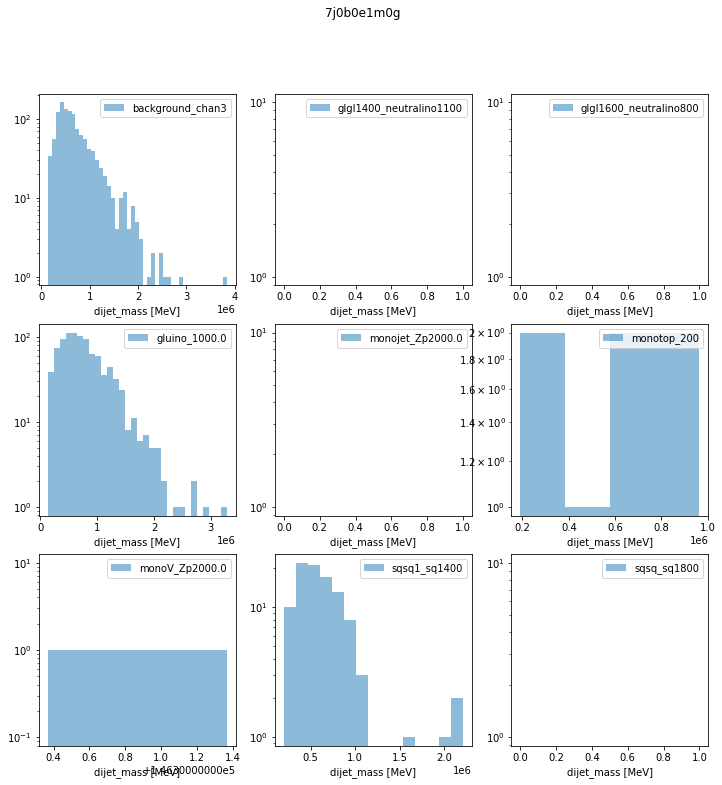

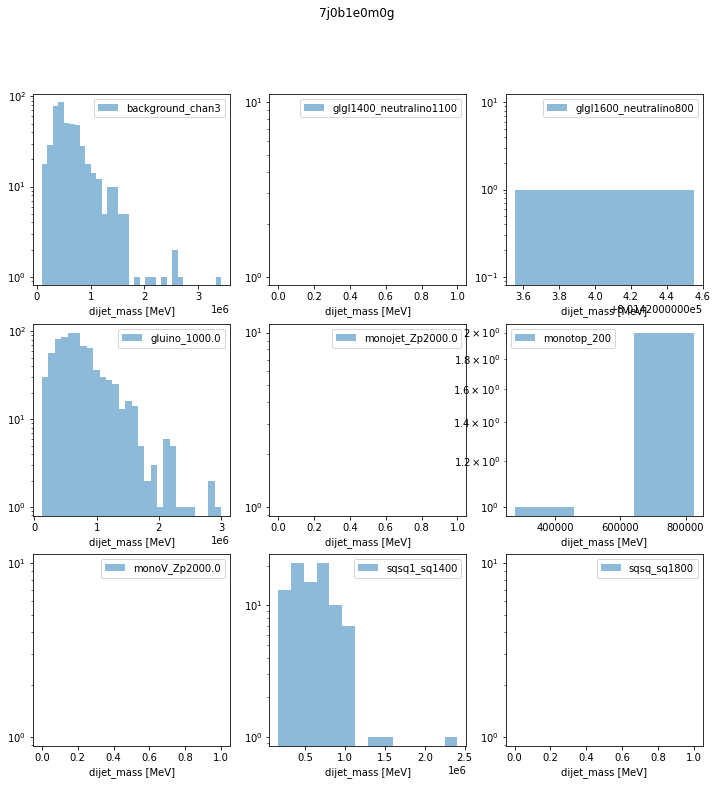

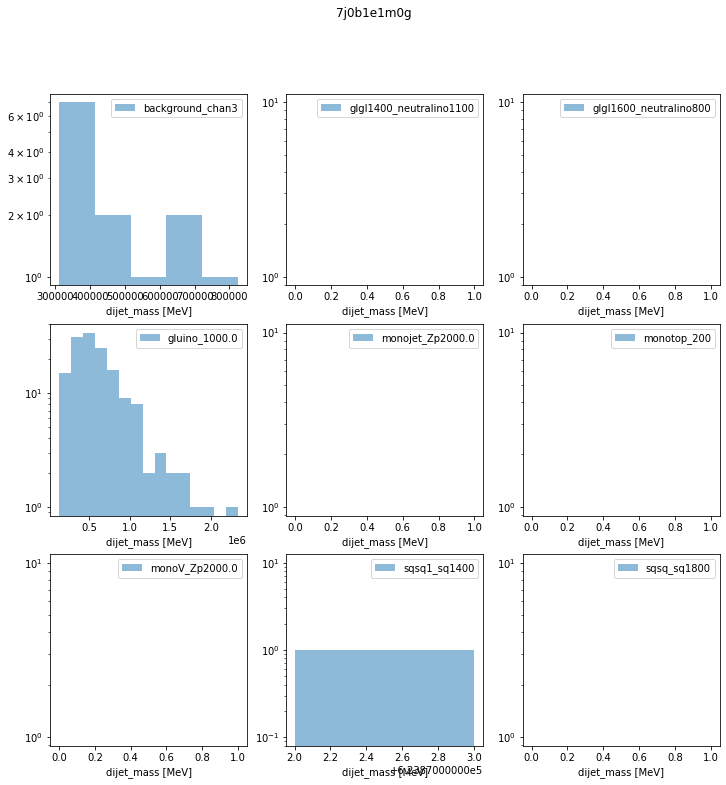

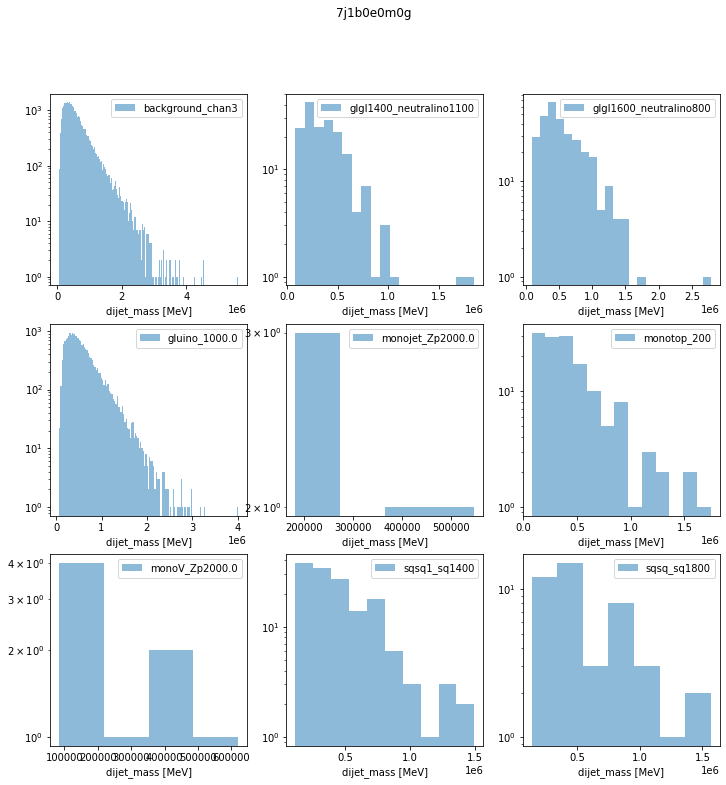

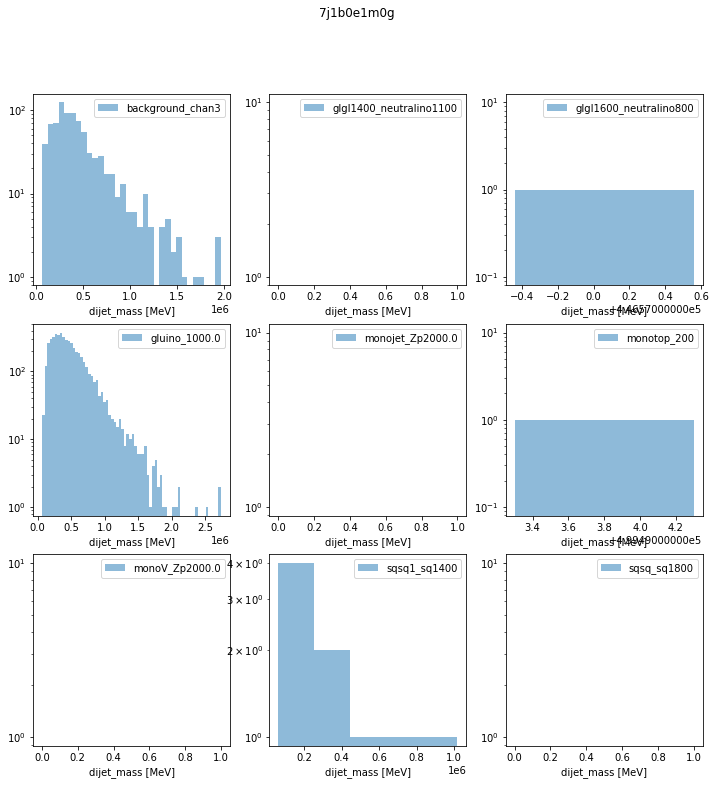

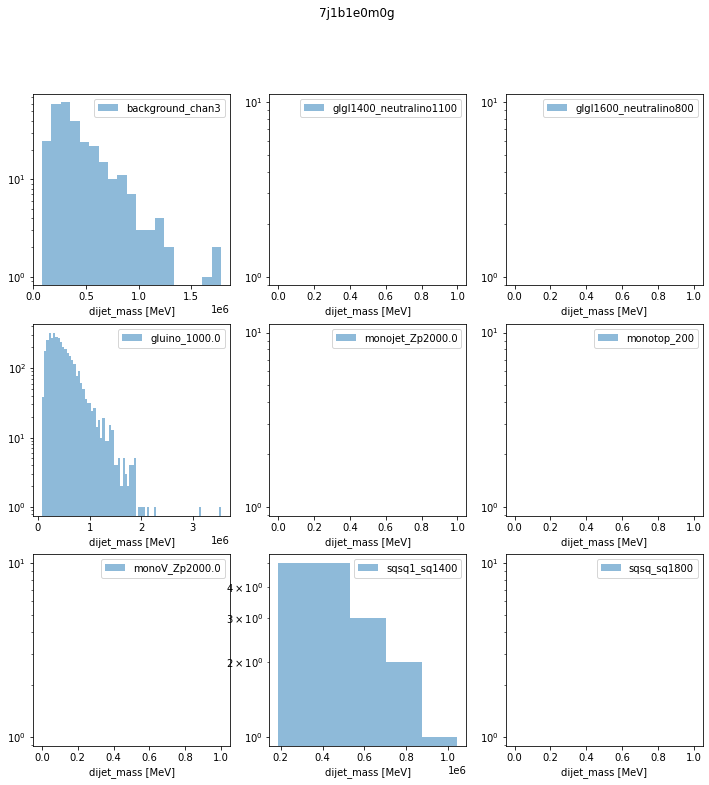

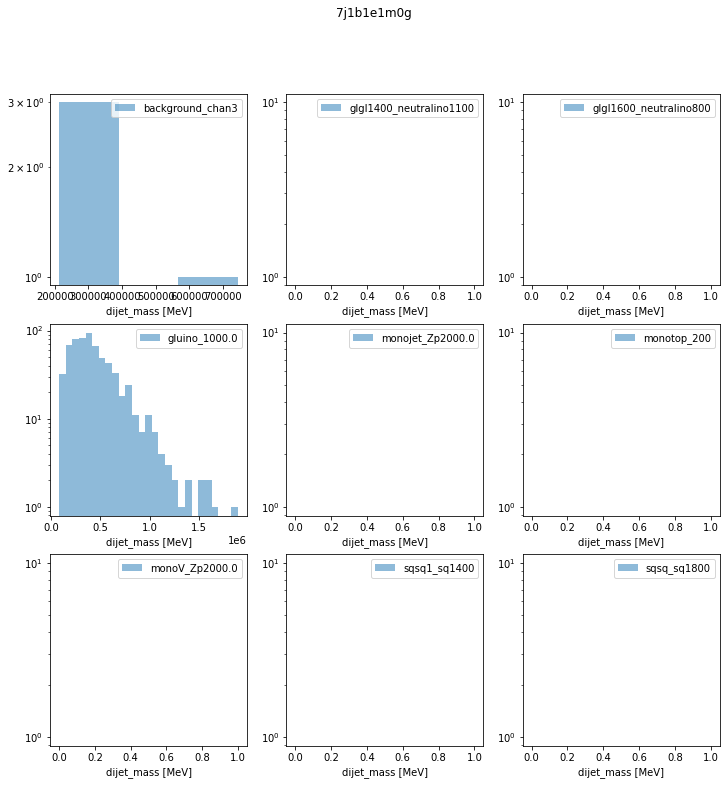

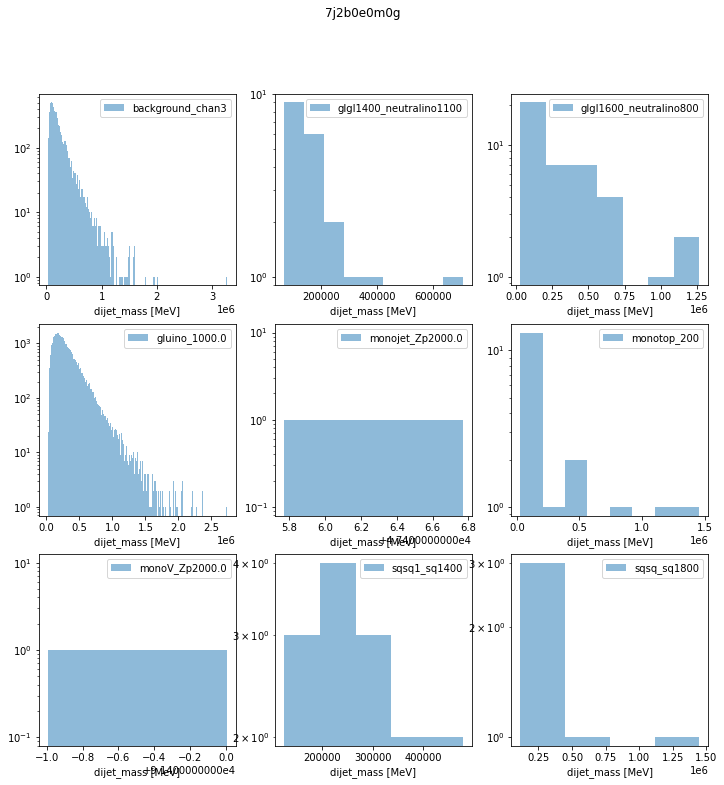

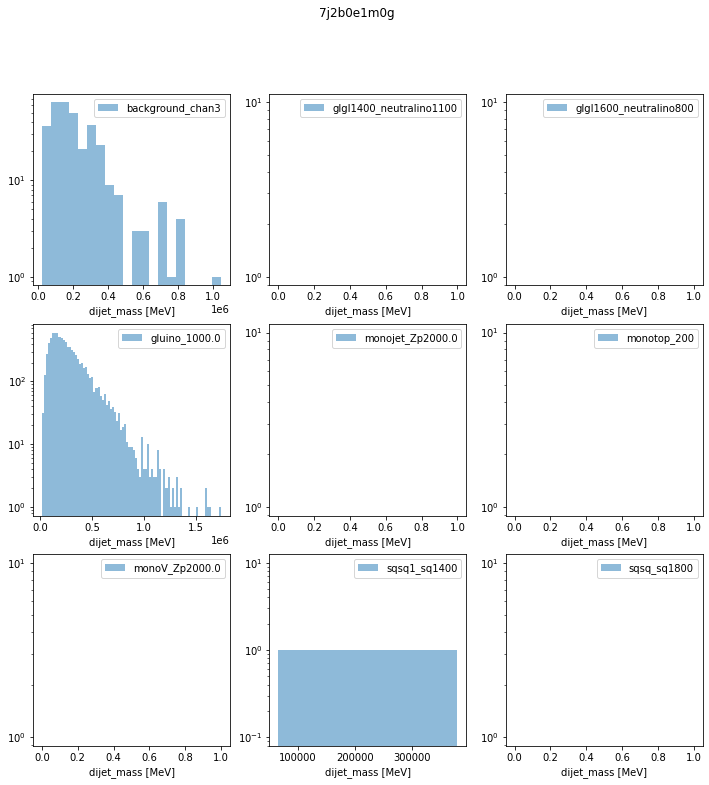

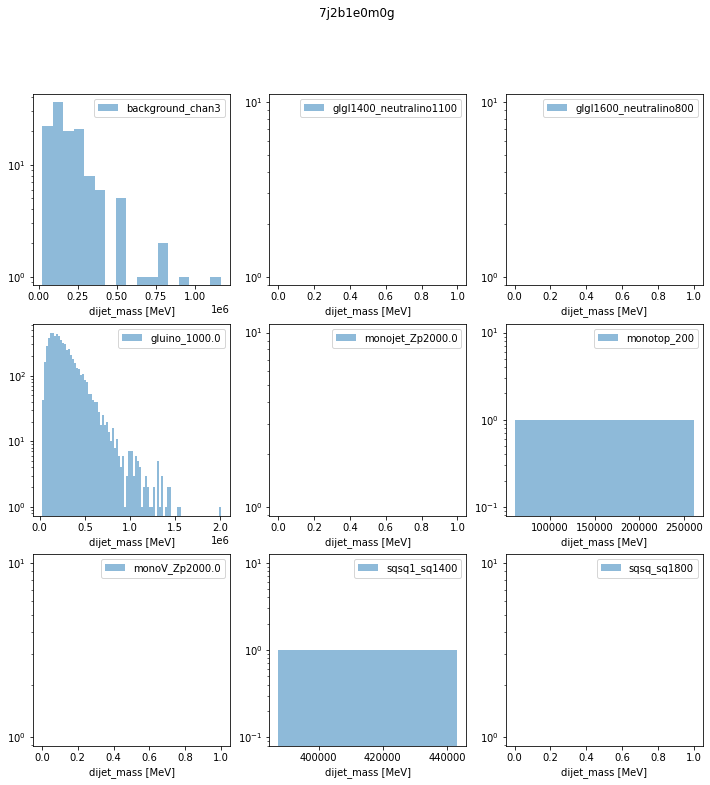

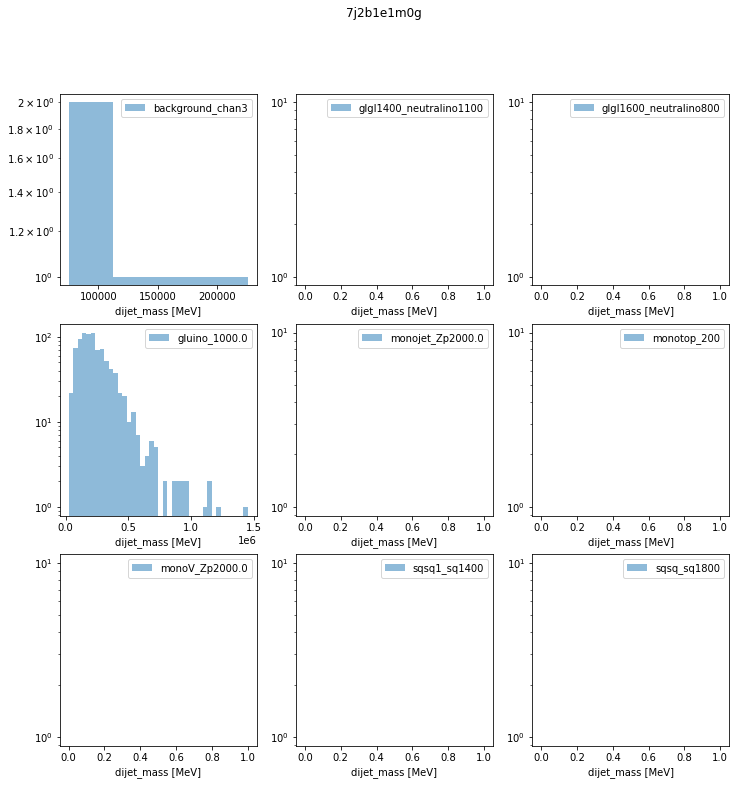

In [14]:
for sel in selection:
    print("\nselection:",sel)
    
    # Read background
    bkg, features = ReadFiles(files_to_process_sm, DATAPATH, sel)
    
    # Read signal
    sig, features = ReadFiles(files_to_process_bsm, DATAPATH2, sel)
    
    # Add Ht and Htall variables    
    list_Htall = [s for s in features if 'pt' in s] # list of all features containing 'pt'
    list_Ht = [s for s in features if 'pt' in s and ('j' in s or 'b' in s)] # list of all jet and b-jet features containing 'pt'
    for i in bkg:
        df = bkg[i]
        addfeatures(df,list_Htall,list_Ht)
    for i in sig:
        df = sig[i]
        addfeatures(df,list_Htall,list_Ht)
    
    # Add syst invariant mass variables
    #add4vect_system(bkg, sel)
    #add4vect_system(sig, sel)
    
    # Add dijet mass
    add4vect_dijet(bkg, sel)
    add4vect_dijet(sig, sel)
    
    # Make plots
    nj,nb,ne,nm,ng = sel
    selname = "%dj%db%de%dm%dg" % (nj,nb,ne,nm,ng)
    plt.figure(figsize=(12, 12))
    plt.suptitle(selname)
    
    # Write output files
    x_varname='dijet_mass'
    for i in bkg:
        ff = i+".csv"
        df = bkg[i]
        savefile(ff,sel,df.loc[:,['weight','MET',x_varname]])
        plt.subplot(3, 3, 1)
        _ = plt.hist(df[x_varname], bins='auto', alpha=0.5, label=i, density=0, log=True)
        plt.xlabel(x_varname+" [MeV]")
        plt.legend(loc='best')
    
    cnt=1
    for i in sig:
        ff = i+".csv"
        df = sig[i]
        savefile(ff,sel,df.loc[:,['weight','MET',x_varname]])
        cnt+=1
        if (cnt<10):
            plt.subplot(3, 3, cnt)
            _ = plt.hist(df[x_varname], bins='auto', alpha=0.5, label=i, density=0, log=True)
            plt.xlabel(x_varname+" [MeV]")
            plt.legend(loc='best')

## Search panda columns
https://towardsdatascience.com/interesting-ways-to-select-pandas-dataframe-columns-b29b82bbfb33

---

## Read data and add features

## Look at data

## Plot 4-vectors of all particles